In [18]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [2]:
# open saved data
with open('x_df', 'rb') as x:
    combine_df = pickle.load(x)

with open('y_df', 'rb') as y:
    y_df = pickle.load(y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(combine_df, y_df, test_size=0.2, random_state = 32)

### Normalization

Apply scaling only on the X_train to avoid potential data leakage. If applied scaling on the entire dataset, including the test data, it will use the information from the testing set to scale the data, which could lead to biased and inaccurate results.

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the fitted scaling on X_test
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [16]:
# Create a logistic regression model
lr = LogisticRegression()

# Define the parameter grid for grid search
param_grid = {'C': [0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Create a grid search object with 5-fold cross-validation
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the grid search object on the training set
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best AUC score
print("Best parameters: ", grid_search.best_params_)
print("Best AUC score: ", grid_search.best_score_)

c:\Users\YunL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\YunL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Best parameters:  {'C': 1, 'penalty': 'l2'}
Best AUC score:  0.7632017669731677


c:\Users\YunL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# Get the best model from the grid search object
best_model = grid_search.best_estimator_

# Select features using L1-based feature selection
feature_selector = SelectFromModel(best_model, prefit=True, threshold='median')
X_train_selected = feature_selector.transform(X_train_scaled)

# Get the selected feature indices
selected_indices = feature_selector.get_support(indices=True)

# Transform the testing set using the same feature selection
X_test_scaled = scaler.transform(X_test)
X_test_selected = feature_selector.transform(X_test_scaled)

# Evaluate the model using 5-fold cross-validation and AUC score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=cv, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation AUC scores: ", cv_scores)

# Fit the best model on the entire training set and get the AUC score on the testing set
best_model.fit(X_train_selected, y_train)
y_pred_proba = best_model.predict_proba(X_test_selected)[:,1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)

# Print the AUC score
train_auc_score = grid_search.best_score_
print("Train AUC score: ", train_auc_score)
print("Test AUC score: ", test_auc_score)

c:\Users\YunL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\YunL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Cross-validation AUC scores:  [0.76638914 0.77105634 0.76276385 0.76073068 0.77607062]
Train AUC score:  0.7632017669731677
Test AUC score:  0.7635697211433786


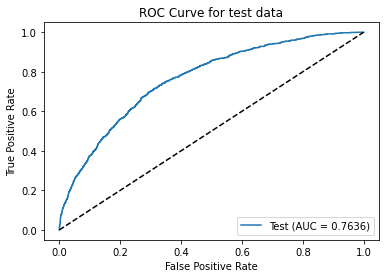

In [20]:
# Compute the false positive rate and true positive rate for testing set
test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve for the testing set on the same graph
plt.plot(test_fpr, test_tpr, label='Test (AUC = {:.4f})'.format(test_auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for test data')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Save the logistic model
with open('lr_clf', 'wb') as c:
    pickle.dump(best_model, c, pickle.HIGHEST_PROTOCOL)

### Model 1: Random Forest

In [5]:
# Random Forest Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
}

In [6]:
# Initialize grid search
# Find the best hyperparameters for the model, based on the performance on the training set
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_

In [7]:
# Fit the model & feature importance
rf = RandomForestClassifier(**best_params)
rf.fit(X_train_scaled, y_train)
feature_importances = rf.feature_importances_

In [8]:
# K-fold cross validation
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='roc_auc')
mean_cv_score = np.mean(cv_scores)

In [11]:
# Evaluate model performance using AUC
X_test_scaled = scaler.transform(X_test)
y_pred = rf.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)
print(auc_score)

0.7391758188827067


In [15]:
# Save the logistic model
with open('rf', 'wb') as c:
    pickle.dump(rf, c, pickle.HIGHEST_PROTOCOL)

In [10]:
print('Best Hyperparameters:', best_params)
print('Feature Importances:', feature_importances)

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Feature Importances: [1.34901093e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.36115085e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.28648421e-02 1.79685745e-02 0.00000000e+00
 7.05898140e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.24146809e-04
 1.80026958e-03 0.00000000e+00 0.00000000e+00 9.84421171e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.12475706e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.58351965e-04 1.68375135e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.12331446e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.16700207e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.

### SVM

In [12]:
#setup grid search
grid_parameters = [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]
                    }
                ]

#run grid search to find best gamma
svm_clf = GridSearchCV(SVC(probability=True),
                   grid_parameters,
                   cv=3,
                   scoring='roc_auc',
                   n_jobs = -1)

svm_clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             scoring='roc_auc')

In [13]:
#Generate predicted probabilites
clf_probs = svm_clf.predict_proba(X_test_scaled)
print('AUC: ', roc_auc_score(y_test, clf_probs[:,1]))
print('Accuracy: ', svm_clf.score(X_test_scaled, y_test))

AUC:  0.7113496796246039
Accuracy:  0.7113897359080498


In [14]:
# Save the logistic model
with open('svm_clf', 'wb') as c:
    pickle.dump(svm_clf, c, pickle.HIGHEST_PROTOCOL)